In [7]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
import torch
from torch.nn import Sequential
import torch.onnx

from resnet50 import ResNet50, Residual_block, Shortcut_projection
from simclr import Encoder, get_projection_head, get_inference_model


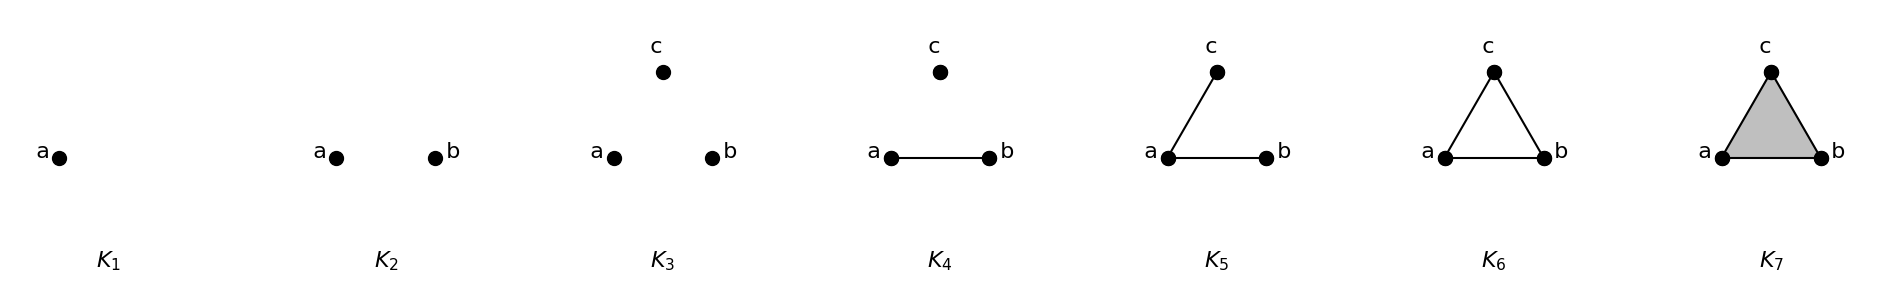

In [1]:
# Simplicial complex dioagram

# Points coordinates
points = {
    'a': (0, 0),
    'b': (1, 0),
    'c': (0.5, np.sqrt(3)/2)
}

fig, axes = plt.subplots(1, 7, figsize=(24, 3), gridspec_kw={'wspace': 0.4})

# Adding points step by step
for i, ax in enumerate(axes[:7]):
    point_labels = list(points.keys())[:i+1]
    ax.scatter(*zip(*[points[label] for label in point_labels]), color='black', s=100, marker='o')
    for label in point_labels:
        x, y = points[label]
        match label:
            case 'a':
                offset = (x-0.1, y)
            case 'b':
                offset = (x+0.25, y)
            case 'c':
                offset = (x, y+0.2)
        ax.text(x, y, f'  {label}', fontsize=16, ha='right', color='black', position=offset)
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    ax.set_frame_on(True)

# Adding lines step by step and adjusting labels
lines = [('a', 'b'), ('c', 'a'), ('b', 'c')]
for i, ax in enumerate(axes[3:6], start=1):
    ax.scatter(*zip(*points.values()), color='black', s=100, marker='o')
    for start, end in lines[:i]:
        x_values = [points[start][0], points[end][0]]
        y_values = [points[start][1], points[end][1]]
        ax.plot(x_values, y_values, color='black')
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    ax.set_frame_on(True)

# Final subplot with grayed-in triangle
axes[-1].fill(*zip(*points.values()), color='gray', alpha=0.5, zorder=0)
axes[-1].scatter(*zip(*points.values()), color='black', s=100, marker='o', zorder=1)
for start, end in lines:
    x_values = [points[start][0], points[end][0]]
    y_values = [points[start][1], points[end][1]]
    axes[-1].plot(x_values, y_values, color='black', zorder=2)
axes[-1].set_aspect('equal')
axes[-1].set_xlim(-0.5, 1.5)
axes[-1].set_ylim(-0.5, 1.5)
axes[-1].axis('off')
axes[-1].set_frame_on(True)

# Add borders to all subplots and add k_i labels at the bottom
for i, ax in enumerate(axes.flatten()):
    ax.set_frame_on(True)  # Adding border
    if i < 7:
        ax.text(0.5, -0.3, f'$K_{{{i+1}}}$', fontsize=16, ha='center', transform=ax.transAxes)
plt.savefig('../report-images/example_simplicial_complex.pdf', format='pdf', dpi=300)
plt.show()

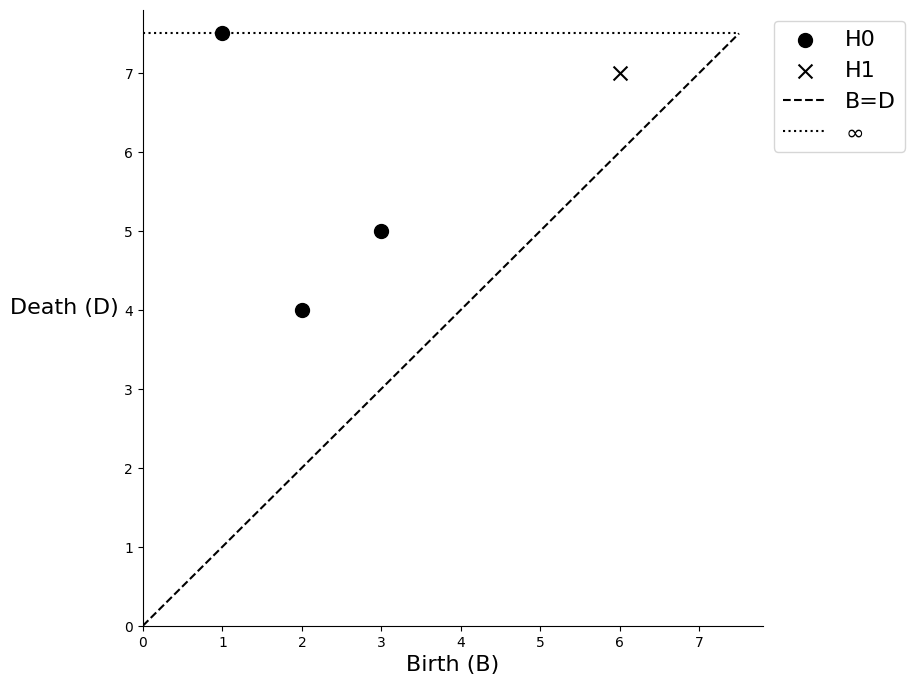

In [21]:
# Persistent Diagram

# Points coordinates for H0 and H1
H0 = [(1, 7.5), (2, 4), (3, 5)]
H1 = [(6, 7)]

# Create the plot
plt.figure(figsize=(8, 8))

# Plot H0 with circle markers
for x, y in H0:
    plt.scatter(x, y, color='black', s=100, marker='o', label='H0' if x == H0[0][0] else "")

# Plot H1 with cross markers
for x, y in H1:
    plt.scatter(x, y, color='black', s=100, marker='x', label='H1' if x == H1[0][0] else "")

# Plot y=x line
plt.plot([0, 7.5, 7.5], [0, 7.5, 7.5], linestyle='--', color='black', label='B=D')

# Plot dashed horizontal line at y=7.5
plt.plot([0, 7.5], [7.5, 7.5], linestyle=':', color='black', label='∞')

# Set lims
plt.xlim((0,7.8))
plt.ylim((0,7.8))

# Set labels
plt.xlabel('Birth (B)', fontsize=16)
plt.ylabel('Death (D)', rotation=0, ha='right', fontsize=16)

# Add legend
plt.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Remove solid axis lines for the cut-off effect
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.savefig('../report-images/example_persistence_diagram.pdf', format='pdf', dpi=300)
plt.show()



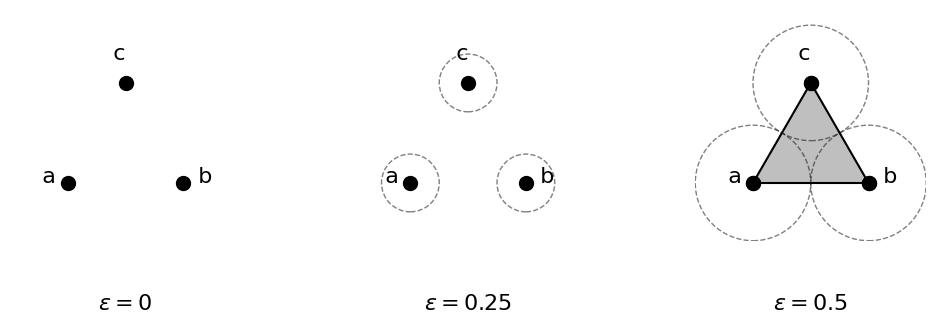

In [34]:
# Generate VR complexes

# Points coordinates
points = {
    'a': (0, 0),
    'b': (1, 0),
    'c': (0.5, np.sqrt(3)/2)
}

fig, axes = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'wspace': 0.4})

# epsilon
epsilon = [0, 0.25, 0.5]

# Adding points step by step
for i, ax in enumerate(axes[:3]):
    ax.scatter(*zip(*points.values()), color='black', s=100, marker='o')
    for label, (x, y) in points.items():
        match label:
            case 'a':
                offset = (x-0.1, y)
            case 'b':
                offset = (x+0.25, y)
            case 'c':
                offset = (x, y+0.2)
        ax.text(x, y, f'  {label}', fontsize=16, ha='right', color='black', position=offset)
        
        # Add circles for the second and third subplots
        if i > 0:
            circle = plt.Circle((x, y), epsilon[i], color='black', fill=False, linestyle='--', alpha=0.5)
            ax.add_artist(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    ax.set_frame_on(True)
    
# Add filled triangle for the third subplot
if i == 2:
    ax.fill(*zip(*points.values()), color='gray', alpha=0.5, zorder=0)

ax.set_aspect('equal')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.axis('off')
ax.set_frame_on(True)

# Add lines for the third subplot
lines = [('a', 'b'), ('c', 'a'), ('b', 'c')]
if i == 2:
    ax.scatter(*zip(*points.values()), color='black', s=100, marker='o')
    for start, end in lines:
        x_values = [points[start][0], points[end][0]]
        y_values = [points[start][1], points[end][1]]
        ax.plot(x_values, y_values, color='black')
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axis('off')
    ax.set_frame_on(True)
    
# Epsilon labels at the bottom
for i, ax in enumerate(axes.flatten()):
    ax.set_frame_on(True)  # Adding border
    if i < 3:
        ax.text(0.5, -0.3, f'$\epsilon={epsilon[i]}$', fontsize=16, ha='center', transform=ax.transAxes)
        
plt.savefig('../report-images/example_VR_complex.pdf', format='pdf', dpi=300)
plt.show()

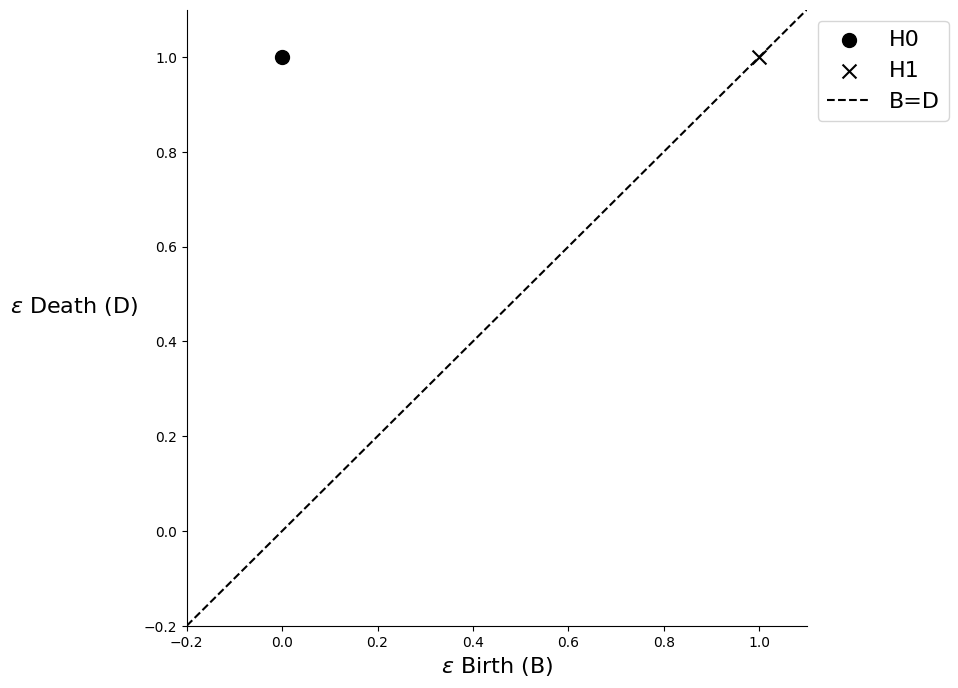

In [48]:
# VR complex Persistent Diagram

# Points coordinates for H0 and H1
H0 = [(0, 1)]
H1 = [(1, 1)]

# Create the plot
plt.figure(figsize=(8, 8))

# Plot H0 with circle markers
for x, y in H0:
    plt.scatter(x, y, color='black', s=100, marker='o', label='H0' if x == H0[0][0] else "")

# Plot H1 with cross markers
for x, y in H1:
    plt.scatter(x, y, color='black', s=100, marker='x', label='H1' if x == H1[0][0] else "")

# Plot y=x line
plt.plot([-0.2, 1.25, 1.25], [-0.2, 1.25, 1.25], linestyle='--', color='black', label='B=D')

# Set lims
plt.xlim((-0.2,1.1))
plt.ylim((-0.2,1.1))

# Set labels
plt.xlabel('$\epsilon$ Birth (B)', fontsize=16)
plt.ylabel('$\epsilon$ Death (D)', rotation=0, ha='right', fontsize=16)

# Add legend
plt.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Remove solid axis lines for the cut-off effect
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# ticks
ticks = np.arange(0, 1.0, 0.1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.axis('on')
ax.set_frame_on(True)

# Show the plot
plt.savefig('../report-images/example_VR_persistence_diagram.pdf', format='pdf', dpi=300)
plt.show()

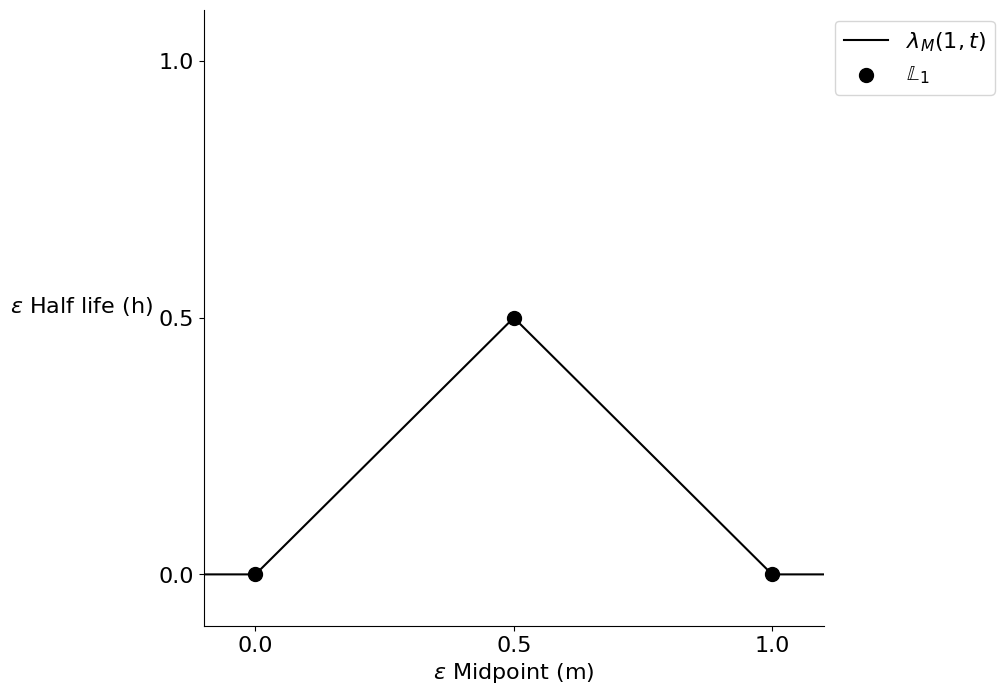

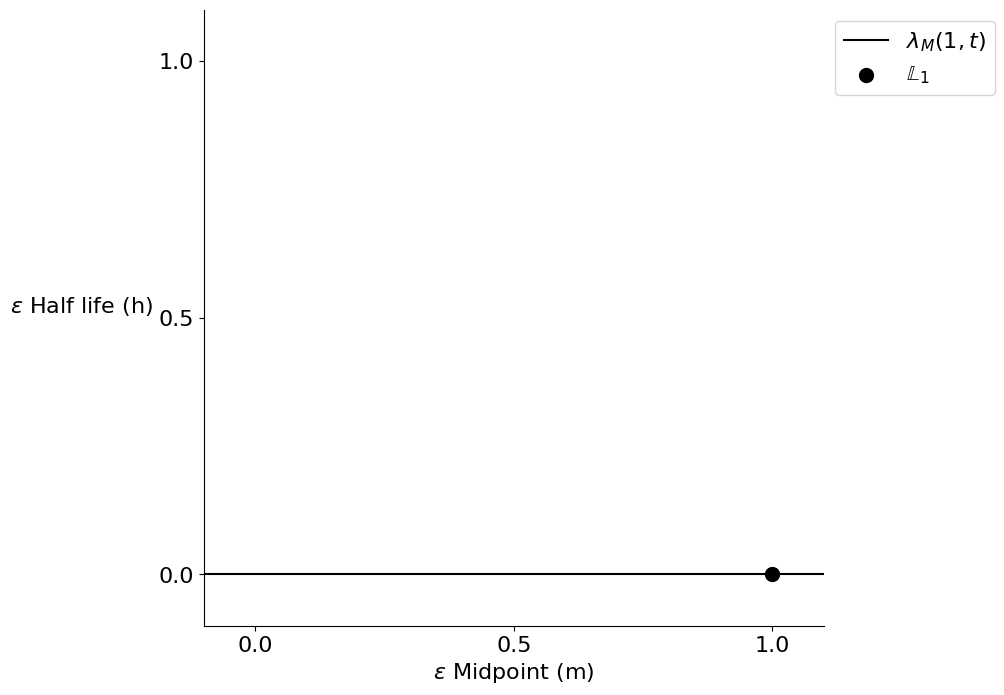

In [16]:
# Single parameter landscapes

# Points for the first plot
points1 = [(0, 0), (0.5, 0.5), (1, 0)]
x=[0, 0.5, 1]
y=[0, 0.5, 0]
# First plot
plt.figure(figsize=(8, 8))
plt.plot([-1, 0, 0.5, 1, 2], [0, 0, 0.5, 0, 0], linestyle='-', color='black', label=r'$\lambda_{M}(1, t)$')
plt.scatter(x, y, color='black', s=100, marker='o', label=r'$\mathbb{L}_{1}$')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks([0, 0.5, 1], fontsize=16)
plt.yticks([0, 0.5, 1], fontsize=16)
plt.xlabel('$\epsilon$ Midpoint (m)', fontsize=16)
plt.ylabel('$\epsilon$ Half life (h)', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../report-images/example_persistence_landscape_H0.pdf', format='pdf', dpi=300)
plt.show()

# Second plot
plt.figure(figsize=(8, 8))
plt.plot([-0.1, 1.1], [0, 0], linestyle='-', color='black', label=r'$\lambda_{M}(1, t)$')
plt.scatter([1], [0], color='black', s=100, marker='o', label=r'$\mathbb{L}_{1}$')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks([0, 0.5, 1], fontsize=16)
plt.yticks([0, 0.5, 1], fontsize=16)
plt.xlabel('$\epsilon$ Midpoint (m)', fontsize=16)
plt.ylabel('$\epsilon$ Half life (h)', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../report-images/example_persistence_landscape_H1.pdf', format='pdf', dpi=300)
plt.show()

In [14]:
Resnet50 = ResNet50(block=Residual_block, in_channels=1, num_classes=3)
y = Resnet50(torch.zeros([64, 1, 64, 64]))
make_dot(y.mean(), params=dict(Resnet50.named_parameters()))
torch.onnx.export(Resnet50, torch.zeros([64, 1, 64, 64]), "model.onnx", opset_version=12)